### Modelling XShooter data with xtool ###

In [1]:
from xtool.data import XShooterData, Order
from xtool.model import OrderModel, GenericBackground, MoffatTrace, VirtualPixelWavelength

from scipy import sparse
from scipy import optimize

#### Reading XShooter data ####

In [2]:
xd = XShooterData('xtool_ds/')

In [3]:
current_order = xd[17]

#### Generating a virtual pixel table for "Wavelength"-pixels ####

In [4]:
virt_pix = VirtualPixelWavelength.from_order(current_order)
pixel_table = virt_pix()

#### Initializing the two Models ####

In [7]:
background_mdl = GenericBackground(pixel_table, virt_pix.wavelength_pixels)
trace_mdl = MoffatTrace(pixel_table, virt_pix.wavelength_pixels)

In [8]:
order_model = OrderModel([background_mdl, trace_mdl])

#### Show fittable parameters ####

In [9]:
order_model

<OrderModel(background_level=[ 0.  0.  0. ...,  0.  0.  0.], amplitude=[ nan  nan  nan ...,  nan  nan  nan], trace_pos=0.0, sigma=1.0, beta=1.5 [f])>

#### Change fittable parameters ####

In [10]:
order_model.trace_pos

Parameter('trace_pos', value=0.0, bounds=(-6, 6))

In [11]:
order_model.trace_pos = 10.

In [12]:
order_model.trace_pos

Parameter('trace_pos', value=10.0, bounds=(-6, 6))

#### Generating a model ####

1. We generate a design matrix (https://en.wikipedia.org/wiki/Design_matrix)
2. We solve the design matrix

The evaluate does both of these steps at the same time

In [15]:
# Generating the design matrix often depicted as capital A

A, model_widths = order_model.generate_design_matrix(current_order, trace_pos=-5, sigma=1.5)

# adding the uncertainties to the design matrix
A.data /= current_order.uncertainty.compressed()[A.row]

# making a vector of the result pixels often depicted as lower-case b

b = current_order.data.compressed() / current_order.uncertainty.compressed()
result = sparse.linalg.lsmr(A, b)

In [16]:
result

(array([ -1.84607069e+03,   5.93872551e+05,   3.70733542e+06, ...,
          1.52388567e+00,   1.24504355e+00,   6.61715836e-01]),
 2,
 8639,
 4613.470857972648,
 0.0024695645829768912,
 0.5353327067182627,
 13429.46405837754,
 2820921905.777216)

In [17]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

#from http://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbg='white')
    ax.plot(m.col, m.row, 's', color='black', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('auto')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('auto')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

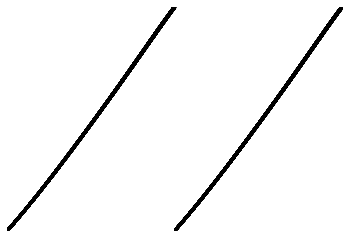

In [19]:
%matplotlib inline

plot_coo_matrix(A)